# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
env_info = env.reset(train_mode=True)[brain_name]

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import copy
from collections import namedtuple, deque
from datetime import datetime

In [9]:
BUFFER_SIZE = int(1e6)      # replay buffer size
BATCH_SIZE = 1024        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 3e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay
LATERAL_LIMIT = 1
JUMP_LIMIT_MAX = 1
JUMP_LIMIT_MIN = 0
ACTOR_FC1_UNITS=128
ACTOR_FC2_UNITS=64
ACTOR_FC3_UNITS=32

CRITIC_FC1_UNITS=128
CRITIC_FC2_UNITS=64
CRITIC_FC3_UNITS=32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

experience_type = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [10]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=ACTOR_FC1_UNITS, fc2_units=ACTOR_FC2_UNITS, fc3_units=ACTOR_FC3_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        self.fc2_small = nn.Linear(fc1_units, action_size)
        self.fc3_small = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        self.fc2_small.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3_small.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2_small(x))
        #x = F.relu(self.fc2(x))
        #return F.tanh(self.fc3_small(x))
        #x = F.relu(self.fc3(x))
        #return F.tanh(self.fc4(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=CRITIC_FC1_UNITS, fc2_units=CRITIC_FC2_UNITS,  fc3_units=ACTOR_FC3_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.fc3_small = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3_small.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action, dim=1):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))      
        x = torch.cat((xs, action), dim=dim)
        x = F.leaky_relu(self.fc2(x))
        #return F.tanh(self.fc3_small(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [11]:
# SumTree : https://github.com/rlcode/per/blob/master/SumTree.py
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity, obj_type):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        #self.data = np.zeros(capacity, dtype=obj_type)
        self.data = [ obj_type(np.zeros(state_size), np.zeros(action_size), 0,np.zeros(state_size), 0) for i in range(capacity) ]
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[dataIdx])

In [12]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree : https://github.com/rlcode/per/blob/master/prioritized_memory.py
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity, obj_type):
        self.tree = SumTree(capacity, obj_type)
        self.capacity = capacity

    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)
        
    def __len__(self):
        return self.tree.n_entries
        
    def sample(self, n = BATCH_SIZE):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)
            

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

In [13]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, replay_buffer=None, actor_local=None, actor_target=None, critic_local=None, critic_target=None):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        if actor_local == None:
            self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        else:
            self.actor_local  = actor_local
            
        if actor_target == None:
            self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        else:
            self.actor_target = actor_target
                 
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        if critic_local == None:
            self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        else:
            self.critic_local = critic_local
        
        if critic_target == None:
            self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        else:
            self.critic_target = critic_target
            
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        if replay_buffer == None:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, experience_type, False)
        else:
            self.memory = replay_buffer
    
    def step(self, states, actions, rewards, next_states, dones, time, common_agent_used):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        t_next_states = torch.from_numpy(np.array(next_states)).float().to(device)
        t_states      = torch.from_numpy(np.array(states     )).float().to(device)
        t_rewards     = torch.from_numpy(np.array(rewards    )).float().to(device)
        t_actions     = torch.from_numpy(np.array(actions    )).float().to(device)
        
        if common_agent_used == True:   
            for state, action, reward, next_state, done, t_state, t_action, t_reward, t_next_state in zip(states, actions, rewards, next_states, dones, t_states, t_actions, t_rewards, t_next_states):
                t_action_next = self.actor_target(t_next_state)
                Q_expected = self.critic_local(t_state, t_action, 0)
                Q_target_next = self.critic_target(t_next_state, t_action_next, 0)
                Q_target = t_reward + (GAMMA * Q_target_next * (1 - done))
                error = torch.abs(Q_expected - Q_target).data.cpu().numpy()
                
                self.memory.add(error, state, action, reward, next_state, done)
        else:
            actions_next = self.actor_target(next_states)
            Q_expected = self.critic_local(states, actions)
            Q_targets_next = self.critic_target(next_states, actions_next)
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
            error = torch.abs(Q_expected - Q_targets).data.cpu().numpy()            
            self.memory.add(error, states, actions, rewards, next_states, dones)
            

        # Learn, if enough samples are available in memory        
        if time %2 == 0:
            if len(self.memory) > BATCH_SIZE:
                for i in range(1):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, common_agent_used)
            
            

    def act(self, state, common_agent_used, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()        
        self.actor_local.train()
               
        if add_noise:
            noise  = self.noise.sample()
            action += noise
        
        if common_agent_used == True:
            for i in range(len(action)):
                action[i][0] = np.clip(action[i][0],-LATERAL_LIMIT, LATERAL_LIMIT)
                action[i][1] = np.clip(np.fabs(action[i][1]),JUMP_LIMIT_MIN, JUMP_LIMIT_MAX)
        else:
            action[0] = np.clip(action[0], -LATERAL_LIMIT, LATERAL_LIMIT)
            action[1] = np.clip(np.fabs(action[1]), JUMP_LIMIT_MIN, JUMP_LIMIT_MAX)

         
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, common_agent_used):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones, ids, is_weight = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
        # ----------------------- update PER ----------------------------------- #
        if ids is not None:
            error_vec = torch.abs(Q_expected - Q_targets).data.cpu().numpy()
        
            for i in range(len(ids)):
                self.memory.update(error_vec[i], ids[i])

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([(random.random() - 0.5) for i in range(len(x))])
        self.state = x + dx
        return self.state
        #return x + dx

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, obj_type, prioritized_replay):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.prioritized_replay = prioritized_replay
        if False == self.prioritized_replay:
            self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        else:
            self.memory = Memory(buffer_size, obj_type)
        self.experience = obj_type
        self.batch_size = batch_size        
        self.seed = random.seed(seed)
    
    def add(self, error, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        if False == self.prioritized_replay:
            self.memory.append(e)
        else:
            self.memory.add(error, e)
    
    def update(self, error, idx):
        if self.prioritized_replay:
            self.memory.update(idx, error)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""        
        if False == self.prioritized_replay:
            experiences = random.sample(self.memory, k=self.batch_size)
            ids = None
            is_weight = None
        else:
            experiences, ids, is_weight = self.memory.sample(n = self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, ids, is_weight)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [14]:
import gym
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
random_seed = 0

common_replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, experience_type, False)
common_actor_local   = Actor(state_size, action_size, random_seed).to(device)
common_actor_target  = Actor(state_size, action_size, random_seed).to(device)
common_critic_local  = Critic(state_size, action_size, random_seed).to(device)
common_critic_target = Critic(state_size, action_size, random_seed).to(device)

sharing_configurations = {
    'NO_SHARING':{'replay_buffer':None,'actor_local':None,'actor_target':None,'critic_local':None,'critic_target':None},
    'REPLAY_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':None,'actor_target':None,'critic_local':None,'critic_target':None},
    'ACTOR_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':common_actor_local,'actor_target':common_actor_target,'critic_local':None,'critic_target':None},
    'CRITIC_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':None,'actor_target':None,'critic_local':common_critic_local,'critic_target':common_critic_target},
    'ALL_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':common_actor_local,'actor_target':common_actor_target,'critic_local':common_critic_local,'critic_target':common_critic_target},
}

current_share_configuration = sharing_configurations['ALL_SHARE']

agents = [Agent(state_size=state_size, action_size=action_size,
                random_seed=random_seed, 
                replay_buffer=current_share_configuration['replay_buffer'],
                actor_local=current_share_configuration['actor_local'],
                actor_target=current_share_configuration['actor_target'],
                critic_local=current_share_configuration['critic_local'],
                critic_target=current_share_configuration['critic_target']
               ) for x in range(num_agents)]

common_agent = Agent(state_size=state_size, action_size=action_size,
                random_seed=random_seed, 
                replay_buffer=current_share_configuration['replay_buffer'],
                actor_local=current_share_configuration['actor_local'], 
                actor_target=current_share_configuration['actor_target'],
                critic_local=current_share_configuration['critic_local'], 
                critic_target=current_share_configuration['critic_target']
               )

In [16]:
def save_model(agent, name):
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(name))
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(name))

In [17]:
def ddpg(n_episodes=10000, max_t=3000, print_every=25, common_agent_used=False):
    scores_deque = deque(maxlen=100)
    scores = []
    average_scores = []
    episode_number = 0
    max_score = 0
    no_change_in_max_score_count = 0
    achieved_threshold = False
    try:
        for i_episode in range(1, n_episodes+1):
            episode_number = i_episode
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            score_agents = []
            if common_agent_used == False:
                score_agents = [0 for agent in agents]
            score_per_episode = [0, 0]
            
            if common_agent_used == False:
                for i in range(len(agents)):
                    agents[i].reset()
            else:
                common_agent.reset()
                
            for t in range(max_t):
                actions = np.zeros((num_agents, action_size))
                if common_agent_used == False:
                    actions = [agent.act(state, False) for agent,state in zip(agents,states)]
                else:
                    actions = [common_agent.act(state, False) for state in states]
                    #actions[0] = common_agent.act(states[0], True)
                    #actions[1] = common_agent.act(states[1], True)                    
                
                env_info = env.step(actions)[brain_name]
                
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                
                if(t % 1 == 0):
                    if common_agent_used == False:
                        for i in range(len(agents)):
                            agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i], t, common_agent_used)
                        for i in range(len(score_agents)):
                            score_agents[i] += np.sum(rewards[i])
                    else:
                        common_agent.step(states, actions, rewards, next_states, dones, t, common_agent_used)
                        score_per_episode[0] += rewards[0]
                        score_per_episode[1] += rewards[1]
                        
                    
                states = next_states
            
                if np.any(dones):
                    break 
                    
            prev_max_score = max_score
            if common_agent_used == False:
                max_score = np.amax(score_agents)
            else:
                max_score = np.amax(score_per_episode)

            if(prev_max_score == max_score):
                no_change_in_max_score_count = no_change_in_max_score_count + 1
            else:
                no_change_in_max_score_count = 0
            
            scores_deque.append(max_score)
            scores.append(max_score)        
            average_score = np.mean(scores_deque)
            average_scores.append(average_score)
            
            update_string = '\rEpisode {}\tAverage Score: {:.4f} : Max Score : {:.4f} : Time : {}'
            print(update_string.format(i_episode, average_score, max_score, datetime.now().time()), end="")
            
            if i_episode % print_every == 0:
                if (achieved_threshold == False):
                    if common_agent_used == False:
                        [save_model(agent, i) for i, agent in enumerate(agents)]
                    else:
                        save_model(common_agent,0)
                print(update_string.format(i_episode, np.mean(scores_deque), max_score, datetime.now().time()))
            
            if average_score >= 0.5:
                achieved_threshold = True
                if common_agent_used == False:
                    [save_model(agent, i) for i, agent in enumerate(agents)]
                else:
                    save_model(common_agent,0)

                print('\nAverage score reached 0.5 at Episode {}'.format(i_episode))
                
            if (no_change_in_max_score_count >= 8000) and (i_episode > 200):
                print('\nNo change in max score detected for {} episodes, ending run'.format(no_change_in_max_score_count))
                break
    except KeyboardInterrupt:
        print('\nDetected Keyboard interrupt, returning after episide {}'.format(episode_number))
        return scores, average_scores, episode_number
            
            
    return scores, average_scores, episode_number


In [18]:
scores, average_scores, episodes_run = ddpg(common_agent_used=True)

Episode 25	Average Score: 0.0040 : Max Score : 0.0000 : Time : 21:57:51.268550
Episode 50	Average Score: 0.0038 : Max Score : 0.0000 : Time : 21:57:56.284830
Episode 75	Average Score: 0.0037 : Max Score : 0.0000 : Time : 21:58:02.255086
Episode 100	Average Score: 0.0028 : Max Score : 0.0000 : Time : 21:58:07.957800
Episode 125	Average Score: 0.0018 : Max Score : 0.0000 : Time : 21:58:13.663077
Episode 150	Average Score: 0.0009 : Max Score : 0.0000 : Time : 21:58:19.289511
Episode 175	Average Score: 0.0000 : Max Score : 0.0000 : Time : 21:58:25.044340
Episode 200	Average Score: 0.0000 : Max Score : 0.0000 : Time : 21:58:30.786277
Episode 225	Average Score: 0.0000 : Max Score : 0.0000 : Time : 21:58:36.608611
Episode 250	Average Score: 0.0000 : Max Score : 0.0000 : Time : 21:58:42.625112
Episode 275	Average Score: 0.0000 : Max Score : 0.0000 : Time : 21:58:48.552145
Episode 300	Average Score: 0.0000 : Max Score : 0.0000 : Time : 21:58:54.309316
Episode 325	Average Score: 0.0000 : Max Sco

Episode 2550	Average Score: 0.0353 : Max Score : 0.0000 : Time : 22:08:12.407975
Episode 2575	Average Score: 0.0353 : Max Score : 0.0000 : Time : 22:08:21.096258
Episode 2600	Average Score: 0.0219 : Max Score : 0.1000 : Time : 22:08:28.647174
Episode 2625	Average Score: 0.0257 : Max Score : 0.1000 : Time : 22:08:37.619220
Episode 2650	Average Score: 0.0292 : Max Score : 0.0900 : Time : 22:08:47.596856
Episode 2675	Average Score: 0.0336 : Max Score : 0.0000 : Time : 22:08:56.434241
Episode 2700	Average Score: 0.0412 : Max Score : 0.1000 : Time : 22:09:05.555940
Episode 2725	Average Score: 0.0372 : Max Score : 0.0000 : Time : 22:09:12.793758
Episode 2750	Average Score: 0.0248 : Max Score : 0.0000 : Time : 22:09:18.850130
Episode 2775	Average Score: 0.0154 : Max Score : 0.0000 : Time : 22:09:24.902098
Episode 2800	Average Score: 0.0058 : Max Score : 0.1000 : Time : 22:09:31.559422
Episode 2825	Average Score: 0.0115 : Max Score : 0.0000 : Time : 22:09:40.721405
Episode 2850	Average Score: 

Episode 5075	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:10.777313
Episode 5100	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:16.862775
Episode 5125	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:23.102712
Episode 5150	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:29.371081
Episode 5175	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:35.443981
Episode 5200	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:41.608267
Episode 5225	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:47.725306
Episode 5250	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:19:53.954056
Episode 5275	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:20:00.435868
Episode 5300	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:20:06.842503
Episode 5325	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:20:13.159037
Episode 5350	Average Score: 0.0000 : Max Score : 0.0000 : Time : 22:20:19.401499
Episode 5375	Average Score: 

Episode 7600	Average Score: 0.1205 : Max Score : 0.1000 : Time : 22:42:56.385152
Episode 7625	Average Score: 0.1135 : Max Score : 0.1000 : Time : 22:43:12.430796
Episode 7650	Average Score: 0.1062 : Max Score : 0.1000 : Time : 22:43:32.679190
Episode 7675	Average Score: 0.1053 : Max Score : 0.1000 : Time : 22:43:49.627293
Episode 7700	Average Score: 0.0945 : Max Score : 0.1000 : Time : 22:44:05.044960
Episode 7725	Average Score: 0.0915 : Max Score : 0.0000 : Time : 22:44:22.080163
Episode 7750	Average Score: 0.0795 : Max Score : 0.1000 : Time : 22:44:36.769279
Episode 7775	Average Score: 0.0754 : Max Score : 0.1900 : Time : 22:44:50.165672
Episode 7800	Average Score: 0.0830 : Max Score : 0.3000 : Time : 22:45:09.926950
Episode 7825	Average Score: 0.0960 : Max Score : 0.2000 : Time : 22:45:32.358656
Episode 7850	Average Score: 0.1133 : Max Score : 0.1000 : Time : 22:45:57.551435
Episode 7875	Average Score: 0.1275 : Max Score : 0.0000 : Time : 22:46:22.163610
Episode 7900	Average Score: 

Episode 8222	Average Score: 0.6130 : Max Score : 0.1000 : Time : 23:00:19.593969
Average score reached 0.5 at Episode 8222
Episode 8223	Average Score: 0.6140 : Max Score : 0.1900 : Time : 23:00:20.990570
Average score reached 0.5 at Episode 8223
Episode 8224	Average Score: 0.6140 : Max Score : 0.1000 : Time : 23:00:21.611782
Average score reached 0.5 at Episode 8224
Episode 8225	Average Score: 0.5940 : Max Score : 0.6000 : Time : 23:00:26.599121

Average score reached 0.5 at Episode 8225
Episode 8226	Average Score: 0.5680 : Max Score : 0.1000 : Time : 23:00:27.693338
Average score reached 0.5 at Episode 8226
Episode 8227	Average Score: 0.5680 : Max Score : 0.1000 : Time : 23:00:28.315027
Average score reached 0.5 at Episode 8227
Episode 8228	Average Score: 0.5530 : Max Score : 0.2000 : Time : 23:00:29.734924
Average score reached 0.5 at Episode 8228
Episode 8229	Average Score: 0.5630 : Max Score : 1.2000 : Time : 23:00:39.442253
Average score reached 0.5 at Episode 8229
Episode 8230	Av

Episode 8445	Average Score: 0.5987 : Max Score : 2.7000 : Time : 23:12:08.148289
Average score reached 0.5 at Episode 8445
Episode 8446	Average Score: 0.5978 : Max Score : 0.0000 : Time : 23:12:08.278396
Average score reached 0.5 at Episode 8446
Episode 8447	Average Score: 0.6068 : Max Score : 1.0000 : Time : 23:12:16.248019
Average score reached 0.5 at Episode 8447
Episode 8448	Average Score: 0.6058 : Max Score : 0.0000 : Time : 23:12:16.552805
Average score reached 0.5 at Episode 8448
Episode 8449	Average Score: 0.5808 : Max Score : 0.1000 : Time : 23:12:17.915263
Average score reached 0.5 at Episode 8449
Episode 8450	Average Score: 0.5788 : Max Score : 0.0000 : Time : 23:12:18.210108

Average score reached 0.5 at Episode 8450
Episode 8451	Average Score: 0.5788 : Max Score : 0.1000 : Time : 23:12:18.887621
Average score reached 0.5 at Episode 8451
Episode 8452	Average Score: 0.5788 : Max Score : 0.1000 : Time : 23:12:19.861503
Average score reached 0.5 at Episode 8452
Episode 8453	Av

Episode 8512	Average Score: 0.8726 : Max Score : 0.1000 : Time : 23:18:05.570044
Average score reached 0.5 at Episode 8512
Episode 8513	Average Score: 0.8476 : Max Score : 0.1000 : Time : 23:18:06.211946
Average score reached 0.5 at Episode 8513
Episode 8514	Average Score: 0.8476 : Max Score : 0.1000 : Time : 23:18:07.559842
Average score reached 0.5 at Episode 8514
Episode 8515	Average Score: 0.8566 : Max Score : 0.9000 : Time : 23:18:14.823013
Average score reached 0.5 at Episode 8515
Episode 8516	Average Score: 0.8616 : Max Score : 0.7000 : Time : 23:18:20.502867
Average score reached 0.5 at Episode 8516
Episode 8517	Average Score: 0.8646 : Max Score : 0.4000 : Time : 23:18:23.795126
Average score reached 0.5 at Episode 8517
Episode 8518	Average Score: 0.8646 : Max Score : 0.1000 : Time : 23:18:24.442714
Average score reached 0.5 at Episode 8518
Episode 8519	Average Score: 0.8436 : Max Score : 0.1000 : Time : 23:18:25.093417
Average score reached 0.5 at Episode 8519
Episode 8520	Ave

Episode 8579	Average Score: 0.5651 : Max Score : 0.0900 : Time : 23:21:47.225447
Average score reached 0.5 at Episode 8579
Episode 8580	Average Score: 0.5721 : Max Score : 0.8000 : Time : 23:21:54.690204
Average score reached 0.5 at Episode 8580
Episode 8581	Average Score: 0.5561 : Max Score : 0.2000 : Time : 23:21:56.486683
Average score reached 0.5 at Episode 8581
Episode 8582	Average Score: 0.5321 : Max Score : 0.2000 : Time : 23:21:58.007396
Average score reached 0.5 at Episode 8582
Episode 8583	Average Score: 0.5070 : Max Score : 0.1900 : Time : 23:21:59.476095
Average score reached 0.5 at Episode 8583
Episode 8584	Average Score: 0.5070 : Max Score : 2.6000 : Time : 23:22:21.284268
Average score reached 0.5 at Episode 8584
Episode 8588	Average Score: 0.5230 : Max Score : 2.6000 : Time : 23:22:57.630207
Average score reached 0.5 at Episode 8588
Episode 8600	Average Score: 0.4849 : Max Score : 2.2000 : Time : 23:23:36.276489
Episode 8603	Average Score: 0.5049 : Max Score : 2.2000 : 

Episode 8727	Average Score: 0.6507 : Max Score : 1.6000 : Time : 23:34:33.806759
Average score reached 0.5 at Episode 8727
Episode 8728	Average Score: 0.6507 : Max Score : 0.1000 : Time : 23:34:34.614005
Average score reached 0.5 at Episode 8728
Episode 8729	Average Score: 0.6518 : Max Score : 0.2000 : Time : 23:34:36.285832
Average score reached 0.5 at Episode 8729
Episode 8730	Average Score: 0.6518 : Max Score : 0.1000 : Time : 23:34:37.009627
Average score reached 0.5 at Episode 8730
Episode 8731	Average Score: 0.6527 : Max Score : 0.0900 : Time : 23:34:37.727193
Average score reached 0.5 at Episode 8731
Episode 8732	Average Score: 0.6537 : Max Score : 0.2000 : Time : 23:34:39.376067
Average score reached 0.5 at Episode 8732
Episode 8733	Average Score: 0.6787 : Max Score : 2.6000 : Time : 23:35:03.016845
Average score reached 0.5 at Episode 8733
Episode 8734	Average Score: 0.7048 : Max Score : 2.7000 : Time : 23:35:26.807528
Average score reached 0.5 at Episode 8734
Episode 8735	Ave

Episode 8794	Average Score: 1.0156 : Max Score : 0.1000 : Time : 23:45:35.010514
Average score reached 0.5 at Episode 8794
Episode 8795	Average Score: 1.0146 : Max Score : 0.1000 : Time : 23:45:36.319732
Average score reached 0.5 at Episode 8795
Episode 8796	Average Score: 1.0396 : Max Score : 2.6000 : Time : 23:46:00.796694
Average score reached 0.5 at Episode 8796
Episode 8797	Average Score: 1.0406 : Max Score : 0.2000 : Time : 23:46:02.428394
Average score reached 0.5 at Episode 8797
Episode 8798	Average Score: 1.0666 : Max Score : 2.6000 : Time : 23:46:26.628998
Average score reached 0.5 at Episode 8798
Episode 8799	Average Score: 1.0666 : Max Score : 0.1000 : Time : 23:46:27.706055
Average score reached 0.5 at Episode 8799
Episode 8800	Average Score: 1.0666 : Max Score : 0.1000 : Time : 23:46:29.255117

Average score reached 0.5 at Episode 8800
Episode 8801	Average Score: 1.0656 : Max Score : 0.1000 : Time : 23:46:29.979845
Average score reached 0.5 at Episode 8801
Episode 8802	Av

Episode 8861	Average Score: 0.9761 : Max Score : 0.1000 : Time : 23:55:21.466133
Average score reached 0.5 at Episode 8861
Episode 8862	Average Score: 0.9761 : Max Score : 2.6000 : Time : 23:55:47.147290
Average score reached 0.5 at Episode 8862
Episode 8863	Average Score: 0.9501 : Max Score : 0.1000 : Time : 23:55:48.272586
Average score reached 0.5 at Episode 8863
Episode 8864	Average Score: 0.9751 : Max Score : 2.6000 : Time : 23:56:13.602922
Average score reached 0.5 at Episode 8864
Episode 8865	Average Score: 0.9501 : Max Score : 0.1000 : Time : 23:56:14.671620
Average score reached 0.5 at Episode 8865
Episode 8866	Average Score: 0.9251 : Max Score : 0.2000 : Time : 23:56:16.409208
Average score reached 0.5 at Episode 8866
Episode 8867	Average Score: 0.9260 : Max Score : 0.1900 : Time : 23:56:18.106560
Average score reached 0.5 at Episode 8867
Episode 8868	Average Score: 0.9020 : Max Score : 0.2000 : Time : 23:56:19.827524
Average score reached 0.5 at Episode 8868
Episode 8869	Ave

Episode 8928	Average Score: 1.1817 : Max Score : 0.1000 : Time : 00:09:24.323245
Average score reached 0.5 at Episode 8928
Episode 8929	Average Score: 1.1797 : Max Score : 0.1000 : Time : 00:09:26.021700
Average score reached 0.5 at Episode 8929
Episode 8930	Average Score: 1.1557 : Max Score : 0.2000 : Time : 00:09:27.925140
Average score reached 0.5 at Episode 8930
Episode 8931	Average Score: 1.1577 : Max Score : 0.3000 : Time : 00:09:30.788472
Average score reached 0.5 at Episode 8931
Episode 8932	Average Score: 1.1827 : Max Score : 2.6000 : Time : 00:09:58.081437
Average score reached 0.5 at Episode 8932
Episode 8933	Average Score: 1.1837 : Max Score : 2.7000 : Time : 00:10:25.220077
Average score reached 0.5 at Episode 8933
Episode 8934	Average Score: 1.1836 : Max Score : 0.0900 : Time : 00:10:26.032931
Average score reached 0.5 at Episode 8934
Episode 8935	Average Score: 1.1836 : Max Score : 0.1000 : Time : 00:10:26.836470
Average score reached 0.5 at Episode 8935
Episode 8936	Ave

Episode 8995	Average Score: 1.5975 : Max Score : 0.2000 : Time : 00:27:00.354771
Average score reached 0.5 at Episode 8995
Episode 8996	Average Score: 1.5735 : Max Score : 0.2000 : Time : 00:27:02.303318
Average score reached 0.5 at Episode 8996
Episode 8997	Average Score: 1.5746 : Max Score : 0.2000 : Time : 00:27:04.343399
Average score reached 0.5 at Episode 8997
Episode 8998	Average Score: 1.5756 : Max Score : 0.2000 : Time : 00:27:06.356286
Average score reached 0.5 at Episode 8998
Episode 8999	Average Score: 1.6006 : Max Score : 2.6000 : Time : 00:27:35.283122
Average score reached 0.5 at Episode 8999
Episode 9000	Average Score: 1.5996 : Max Score : 0.1000 : Time : 00:27:36.508759

Average score reached 0.5 at Episode 9000
Episode 9001	Average Score: 1.5746 : Max Score : 0.1000 : Time : 00:27:38.196182
Average score reached 0.5 at Episode 9001
Episode 9002	Average Score: 1.5496 : Max Score : 0.2000 : Time : 00:27:40.166352
Average score reached 0.5 at Episode 9002
Episode 9003	Av

Episode 9062	Average Score: 1.2237 : Max Score : 0.2000 : Time : 00:39:18.570538
Average score reached 0.5 at Episode 9062
Episode 9063	Average Score: 1.1997 : Max Score : 0.2000 : Time : 00:39:20.613203
Average score reached 0.5 at Episode 9063
Episode 9064	Average Score: 1.1737 : Max Score : 0.1000 : Time : 00:39:21.500018
Average score reached 0.5 at Episode 9064
Episode 9065	Average Score: 1.1487 : Max Score : 0.1000 : Time : 00:39:22.391847
Average score reached 0.5 at Episode 9065
Episode 9066	Average Score: 1.1237 : Max Score : 0.2000 : Time : 00:39:24.391246
Average score reached 0.5 at Episode 9066
Episode 9067	Average Score: 1.0997 : Max Score : 0.2000 : Time : 00:39:26.398783
Average score reached 0.5 at Episode 9067
Episode 9068	Average Score: 1.1237 : Max Score : 2.6000 : Time : 00:39:55.438730
Average score reached 0.5 at Episode 9068
Episode 9069	Average Score: 1.1487 : Max Score : 2.7000 : Time : 00:40:25.069140
Average score reached 0.5 at Episode 9069
Episode 9070	Ave

Episode 9129	Average Score: 0.9656 : Max Score : 0.1000 : Time : 00:52:52.141091
Average score reached 0.5 at Episode 9129
Episode 9130	Average Score: 0.9666 : Max Score : 0.2000 : Time : 00:52:54.342744
Average score reached 0.5 at Episode 9130
Episode 9131	Average Score: 0.9666 : Max Score : 0.2000 : Time : 00:52:56.468624
Average score reached 0.5 at Episode 9131
Episode 9132	Average Score: 0.9667 : Max Score : 0.2000 : Time : 00:52:58.563855
Average score reached 0.5 at Episode 9132
Episode 9133	Average Score: 0.9658 : Max Score : 0.1000 : Time : 00:52:59.468376
Average score reached 0.5 at Episode 9133
Episode 9134	Average Score: 0.9428 : Max Score : 0.3000 : Time : 00:53:03.408803
Average score reached 0.5 at Episode 9134
Episode 9135	Average Score: 0.9178 : Max Score : 0.2000 : Time : 00:53:05.596282
Average score reached 0.5 at Episode 9135
Episode 9136	Average Score: 0.9418 : Max Score : 2.5000 : Time : 00:53:34.348697
Average score reached 0.5 at Episode 9136
Episode 9137	Ave

Episode 9196	Average Score: 0.7184 : Max Score : 0.1000 : Time : 01:00:22.059977
Average score reached 0.5 at Episode 9196
Episode 9197	Average Score: 0.6934 : Max Score : 0.1000 : Time : 01:00:23.712604
Average score reached 0.5 at Episode 9197
Episode 9198	Average Score: 0.6684 : Max Score : 0.2000 : Time : 01:00:26.541829
Average score reached 0.5 at Episode 9198
Episode 9199	Average Score: 0.6444 : Max Score : 0.2000 : Time : 01:00:29.360536
Average score reached 0.5 at Episode 9199
Episode 9200	Average Score: 0.6344 : Max Score : 1.7000 : Time : 01:00:50.084949

Average score reached 0.5 at Episode 9200
Episode 9201	Average Score: 0.6154 : Max Score : 0.7000 : Time : 01:00:58.925416
Average score reached 0.5 at Episode 9201
Episode 9202	Average Score: 0.6154 : Max Score : 0.2000 : Time : 01:01:02.083879
Average score reached 0.5 at Episode 9202
Episode 9203	Average Score: 0.6154 : Max Score : 0.1000 : Time : 01:01:04.104034
Average score reached 0.5 at Episode 9203
Episode 9204	Av

Episode 9263	Average Score: 0.6154 : Max Score : 2.7000 : Time : 01:09:22.515508
Average score reached 0.5 at Episode 9263
Episode 9264	Average Score: 0.5894 : Max Score : 0.1000 : Time : 01:09:23.480413
Average score reached 0.5 at Episode 9264
Episode 9265	Average Score: 0.6004 : Max Score : 2.6000 : Time : 01:09:55.703863
Average score reached 0.5 at Episode 9265
Episode 9266	Average Score: 0.6034 : Max Score : 0.4000 : Time : 01:09:59.841249
Average score reached 0.5 at Episode 9266
Episode 9267	Average Score: 0.5784 : Max Score : 0.1000 : Time : 01:10:00.811586
Average score reached 0.5 at Episode 9267
Episode 9268	Average Score: 0.5654 : Max Score : 0.2000 : Time : 01:10:03.757927
Average score reached 0.5 at Episode 9268
Episode 9269	Average Score: 0.5423 : Max Score : 0.2900 : Time : 01:10:07.124096
Average score reached 0.5 at Episode 9269
Episode 9270	Average Score: 0.5433 : Max Score : 2.6000 : Time : 01:10:39.481409
Average score reached 0.5 at Episode 9270
Episode 9271	Ave

Episode 9330	Average Score: 1.3136 : Max Score : 2.6000 : Time : 01:30:50.593626
Average score reached 0.5 at Episode 9330
Episode 9331	Average Score: 1.3126 : Max Score : 0.1000 : Time : 01:30:51.359233
Average score reached 0.5 at Episode 9331
Episode 9332	Average Score: 1.3366 : Max Score : 2.6000 : Time : 01:31:23.400678
Average score reached 0.5 at Episode 9332
Episode 9333	Average Score: 1.3616 : Max Score : 2.7000 : Time : 01:31:55.529685
Average score reached 0.5 at Episode 9333
Episode 9334	Average Score: 1.3777 : Max Score : 1.7000 : Time : 01:32:16.426997
Average score reached 0.5 at Episode 9334
Episode 9335	Average Score: 1.4027 : Max Score : 2.6000 : Time : 01:32:48.627971
Average score reached 0.5 at Episode 9335
Episode 9336	Average Score: 1.4287 : Max Score : 2.7000 : Time : 01:33:21.184197
Average score reached 0.5 at Episode 9336
Episode 9337	Average Score: 1.4277 : Max Score : 0.1000 : Time : 01:33:23.015798
Average score reached 0.5 at Episode 9337
Episode 9338	Ave

Episode 9397	Average Score: 1.8250 : Max Score : 2.7000 : Time : 01:57:09.656297
Average score reached 0.5 at Episode 9397
Episode 9398	Average Score: 1.8010 : Max Score : 0.2000 : Time : 01:57:11.726513
Average score reached 0.5 at Episode 9398
Episode 9399	Average Score: 1.8000 : Max Score : 2.6000 : Time : 01:57:44.426003
Average score reached 0.5 at Episode 9399
Episode 9400	Average Score: 1.8260 : Max Score : 2.7000 : Time : 01:58:17.022238

Average score reached 0.5 at Episode 9400
Episode 9401	Average Score: 1.8010 : Max Score : 0.1000 : Time : 01:58:17.991191
Average score reached 0.5 at Episode 9401
Episode 9402	Average Score: 1.8000 : Max Score : 2.6000 : Time : 01:58:50.431961
Average score reached 0.5 at Episode 9402
Episode 9403	Average Score: 1.8010 : Max Score : 2.7000 : Time : 01:59:22.959957
Average score reached 0.5 at Episode 9403
Episode 9404	Average Score: 1.8000 : Max Score : 2.6000 : Time : 01:59:55.566853
Average score reached 0.5 at Episode 9404
Episode 9405	Av

Episode 9464	Average Score: 2.1320 : Max Score : 2.6000 : Time : 02:27:09.679890
Average score reached 0.5 at Episode 9464
Episode 9465	Average Score: 2.1330 : Max Score : 2.7000 : Time : 02:27:42.087781
Average score reached 0.5 at Episode 9465
Episode 9466	Average Score: 2.1570 : Max Score : 2.6000 : Time : 02:28:14.472912
Average score reached 0.5 at Episode 9466
Episode 9467	Average Score: 2.1470 : Max Score : 0.1000 : Time : 02:28:15.620487
Average score reached 0.5 at Episode 9467
Episode 9468	Average Score: 2.1470 : Max Score : 2.6000 : Time : 02:28:47.936402
Average score reached 0.5 at Episode 9468
Episode 9469	Average Score: 2.1470 : Max Score : 2.7000 : Time : 02:29:20.162415
Average score reached 0.5 at Episode 9469
Episode 9470	Average Score: 2.1470 : Max Score : 2.6000 : Time : 02:29:52.309341
Average score reached 0.5 at Episode 9470
Episode 9471	Average Score: 2.1470 : Max Score : 2.7000 : Time : 02:30:24.626077
Average score reached 0.5 at Episode 9471
Episode 9472	Ave

Episode 9531	Average Score: 2.1559 : Max Score : 2.6000 : Time : 02:56:13.030946
Average score reached 0.5 at Episode 9531
Episode 9532	Average Score: 2.1569 : Max Score : 2.7000 : Time : 02:56:45.159692
Average score reached 0.5 at Episode 9532
Episode 9533	Average Score: 2.1559 : Max Score : 2.6000 : Time : 02:57:17.351231
Average score reached 0.5 at Episode 9533
Episode 9534	Average Score: 2.1819 : Max Score : 2.7000 : Time : 02:57:49.213316
Average score reached 0.5 at Episode 9534
Episode 9535	Average Score: 2.1819 : Max Score : 2.6000 : Time : 02:58:21.566082
Average score reached 0.5 at Episode 9535
Episode 9536	Average Score: 2.1559 : Max Score : 0.1000 : Time : 02:58:22.596638
Average score reached 0.5 at Episode 9536
Episode 9537	Average Score: 2.1469 : Max Score : 1.7000 : Time : 02:58:43.099432
Average score reached 0.5 at Episode 9537
Episode 9538	Average Score: 2.1459 : Max Score : 2.6000 : Time : 02:59:15.511285
Average score reached 0.5 at Episode 9538
Episode 9539	Ave

Episode 9598	Average Score: 2.0339 : Max Score : 2.6000 : Time : 03:24:35.917228
Average score reached 0.5 at Episode 9598
Episode 9599	Average Score: 2.0349 : Max Score : 2.7000 : Time : 03:25:07.621246
Average score reached 0.5 at Episode 9599
Episode 9600	Average Score: 2.0599 : Max Score : 2.7000 : Time : 03:25:39.736030

Average score reached 0.5 at Episode 9600
Episode 9601	Average Score: 2.0599 : Max Score : 2.6000 : Time : 03:26:11.780273
Average score reached 0.5 at Episode 9601
Episode 9602	Average Score: 2.0599 : Max Score : 2.7000 : Time : 03:26:43.893913
Average score reached 0.5 at Episode 9602
Episode 9603	Average Score: 2.0849 : Max Score : 2.7000 : Time : 03:27:15.828111
Average score reached 0.5 at Episode 9603
Episode 9604	Average Score: 2.0849 : Max Score : 2.6000 : Time : 03:27:47.425375
Average score reached 0.5 at Episode 9604
Episode 9605	Average Score: 2.0849 : Max Score : 2.7000 : Time : 03:28:19.117523
Average score reached 0.5 at Episode 9605
Episode 9606	Av

Episode 9665	Average Score: 1.7288 : Max Score : 0.1000 : Time : 03:45:17.888624
Average score reached 0.5 at Episode 9665
Episode 9666	Average Score: 1.7037 : Max Score : 0.0900 : Time : 03:45:18.868132
Average score reached 0.5 at Episode 9666
Episode 9667	Average Score: 1.7027 : Max Score : 2.6000 : Time : 03:45:50.966720
Average score reached 0.5 at Episode 9667
Episode 9668	Average Score: 1.7037 : Max Score : 2.7000 : Time : 03:46:23.383561
Average score reached 0.5 at Episode 9668
Episode 9669	Average Score: 1.7287 : Max Score : 2.6000 : Time : 03:46:55.482703
Average score reached 0.5 at Episode 9669
Episode 9670	Average Score: 1.7277 : Max Score : 0.1000 : Time : 03:46:56.131003
Average score reached 0.5 at Episode 9670
Episode 9671	Average Score: 1.7277 : Max Score : 2.6000 : Time : 03:47:27.703566
Average score reached 0.5 at Episode 9671
Episode 9672	Average Score: 1.7027 : Max Score : 0.2000 : Time : 03:47:29.341586
Average score reached 0.5 at Episode 9672
Episode 9673	Ave

Episode 9732	Average Score: 1.2782 : Max Score : 2.6000 : Time : 04:01:51.650585
Average score reached 0.5 at Episode 9732
Episode 9733	Average Score: 1.3042 : Max Score : 2.7000 : Time : 04:02:23.574418
Average score reached 0.5 at Episode 9733
Episode 9734	Average Score: 1.3292 : Max Score : 2.6000 : Time : 04:02:55.392962
Average score reached 0.5 at Episode 9734
Episode 9735	Average Score: 1.3552 : Max Score : 2.7000 : Time : 04:03:27.370591
Average score reached 0.5 at Episode 9735
Episode 9736	Average Score: 1.3813 : Max Score : 2.7000 : Time : 04:03:59.404927
Average score reached 0.5 at Episode 9736
Episode 9737	Average Score: 1.3823 : Max Score : 0.2000 : Time : 04:04:01.573234
Average score reached 0.5 at Episode 9737
Episode 9738	Average Score: 1.3833 : Max Score : 0.2000 : Time : 04:04:03.750264
Average score reached 0.5 at Episode 9738
Episode 9739	Average Score: 1.3842 : Max Score : 0.1900 : Time : 04:04:05.913328
Average score reached 0.5 at Episode 9739
Episode 9740	Ave

Episode 9799	Average Score: 1.5604 : Max Score : 0.2000 : Time : 04:23:40.908318
Average score reached 0.5 at Episode 9799
Episode 9800	Average Score: 1.5364 : Max Score : 0.2000 : Time : 04:23:43.178937

Average score reached 0.5 at Episode 9800
Episode 9801	Average Score: 1.5103 : Max Score : 0.0900 : Time : 04:23:44.168531
Average score reached 0.5 at Episode 9801
Episode 9802	Average Score: 1.5103 : Max Score : 2.6000 : Time : 04:24:16.560755
Average score reached 0.5 at Episode 9802
Episode 9803	Average Score: 1.4843 : Max Score : 0.1000 : Time : 04:24:17.202339
Average score reached 0.5 at Episode 9803
Episode 9804	Average Score: 1.4603 : Max Score : 0.2000 : Time : 04:24:19.480078
Average score reached 0.5 at Episode 9804
Episode 9805	Average Score: 1.4593 : Max Score : 0.2000 : Time : 04:24:21.688503
Average score reached 0.5 at Episode 9805
Episode 9806	Average Score: 1.4593 : Max Score : 2.6000 : Time : 04:24:53.890544
Average score reached 0.5 at Episode 9806
Episode 9807	Av

Episode 9866	Average Score: 1.0162 : Max Score : 0.1000 : Time : 04:33:46.844034
Average score reached 0.5 at Episode 9866
Episode 9867	Average Score: 1.0152 : Max Score : 2.6000 : Time : 04:34:18.575876
Average score reached 0.5 at Episode 9867
Episode 9868	Average Score: 0.9912 : Max Score : 0.2000 : Time : 04:34:21.075537
Average score reached 0.5 at Episode 9868
Episode 9869	Average Score: 1.0072 : Max Score : 1.8000 : Time : 04:34:42.617087
Average score reached 0.5 at Episode 9869
Episode 9870	Average Score: 1.0092 : Max Score : 0.4000 : Time : 04:34:47.926561
Average score reached 0.5 at Episode 9870
Episode 9871	Average Score: 1.0092 : Max Score : 0.2000 : Time : 04:34:50.095796
Average score reached 0.5 at Episode 9871
Episode 9872	Average Score: 0.9852 : Max Score : 0.2000 : Time : 04:34:52.270788
Average score reached 0.5 at Episode 9872
Episode 9873	Average Score: 0.9662 : Max Score : 0.8000 : Time : 04:35:02.516710
Average score reached 0.5 at Episode 9873
Episode 9874	Ave

Episode 9933	Average Score: 0.9906 : Max Score : 2.6000 : Time : 04:51:18.909411
Average score reached 0.5 at Episode 9933
Episode 9934	Average Score: 1.0166 : Max Score : 2.7000 : Time : 04:51:51.059397
Average score reached 0.5 at Episode 9934
Episode 9935	Average Score: 1.0416 : Max Score : 2.6000 : Time : 04:52:23.532239
Average score reached 0.5 at Episode 9935
Episode 9936	Average Score: 1.0676 : Max Score : 2.7000 : Time : 04:52:55.937932
Average score reached 0.5 at Episode 9936
Episode 9937	Average Score: 1.0936 : Max Score : 2.7000 : Time : 04:53:28.267811
Average score reached 0.5 at Episode 9937
Episode 9938	Average Score: 1.1186 : Max Score : 2.6000 : Time : 04:54:00.465105
Average score reached 0.5 at Episode 9938
Episode 9939	Average Score: 1.1446 : Max Score : 2.7000 : Time : 04:54:32.461091
Average score reached 0.5 at Episode 9939
Episode 9940	Average Score: 1.1696 : Max Score : 2.6000 : Time : 04:55:04.061156
Average score reached 0.5 at Episode 9940
Episode 9941	Ave

Episode 10000	Average Score: 1.9019 : Max Score : 2.6000 : Time : 05:15:30.655710

Average score reached 0.5 at Episode 10000


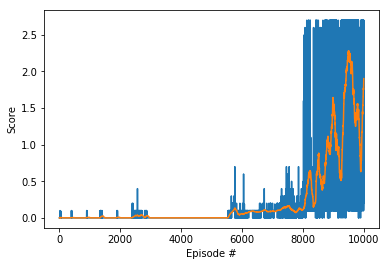

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), average_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [20]:
#print(len(common_replay_buffer.memory.tree.data))
#fig = plt.figure()
#actions = []

#for exp in common_replay_buffer.memory.tree.data:
#    if exp.action.dtype == 'float32' or  exp.action.dtype == 'float64' :
#        actions.append(exp.action)
#    else:
#        try:
#            actions.append(exp.action.data.detach().cpu().numpy())
#        except AttributeError:
#            print(exp.action.dtype)

#print(actions[200])
#print(common_replay_buffer.memory.tree.data[0])
#plt.plot(np.arange(0, len(actions)),actions)

In [21]:
env.close()

In [22]:
a,b,c = common_replay_buffer.memory.sample(20)
#print(b)
print(c)

AttributeError: 'collections.deque' object has no attribute 'sample'